In [1]:
from MagneticFluxRopeModels.ECModel import ECModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
ec_model = ECModel(delta=0.75, psi=0.0)

In [3]:
ec_model

ECModel with parameters:
        - Geometrical:
            - delta = 0.750
            - psi = 0.000 deg
            - R = 0.050 AU
        - Field:
            - n = 1
            - m = 0
            - tau = 1.300
            - C_nm = 1.000
            - B_z_0 = 10.000 nT
            - handedness = 1.

In [4]:
df_wind = pd.read_csv("event_data/wind/2005/12-13-june-2005.csv", sep=";")
df_wind = df_wind.drop("Year", axis=1)
df_wind = df_wind.rename(columns={"Bx": "B_x", "By": "B_y", "Bz": "B_z"})
df_wind.head()

,DOY,millisecs,B,B_x,B_y,B_z,Btheta,Bphi,Vx,Vy,Vz,Np
0,163,199031,7.14,1.05,-7.06,0.04,0.29,278.49,-300.4,-28.2,-18.9,19.3
1,163,297808,6.85,0.25,-6.71,1.22,10.28,272.17,-303.6,-28.3,-15.6,19.2
2,163,390506,6.63,-0.05,-6.47,1.45,12.61,269.55,-302.1,-28.1,-16.9,20.6
3,163,487763,6.57,-0.12,-6.43,1.29,11.33,268.97,-303.8,-28.8,-11.3,19.7
4,163,588094,6.44,-0.45,-6.14,1.87,16.86,265.84,-302.4,-28.2,-16.6,21.3


In [5]:
df_wind.tail()

,DOY,millisecs,B,B_x,B_y,B_z,Btheta,Bphi,Vx,Vy,Vz,Np
1748,164,85950039,4.25,-4.15,-0.68,-0.37,-5.04,189.35,-448.9,-11.1,-2.0,5.2
1749,164,86049656,4.25,-3.11,-2.33,-1.18,-16.96,216.86,-459.9,19.8,-0.7,4.0
1750,164,86145375,4.40,-2.17,-3.37,-1.58,-21.54,237.20,-456.5,31.7,4.3,4.3
1751,164,86241812,4.46,-2.78,-3.09,-1.52,-20.04,227.97,-449.3,33.8,5.3,4.4
1752,164,86362632,4.54,-2.82,-2.95,-1.95,-25.50,226.28,-370.2,33.4,-287.1,12.0


In [6]:
df_wind["time_sec"] = df_wind["millisecs"] / 1000
df_wind["time_sec"] = df_wind["time_sec"] + (df_wind["DOY"] - df_wind["DOY"][0])*(24*3600)
df_wind["time_days"] = df_wind["time_sec"] / (3600 * 24)

In [7]:
df_event = df_wind.loc[(df_wind["time_days"] >= 0.63) & (df_wind["time_days"] <= 1.75)]
df_event = df_event.reset_index(drop=True)
df_event["time"] = df_event["time_sec"] - df_event["time_sec"][0]

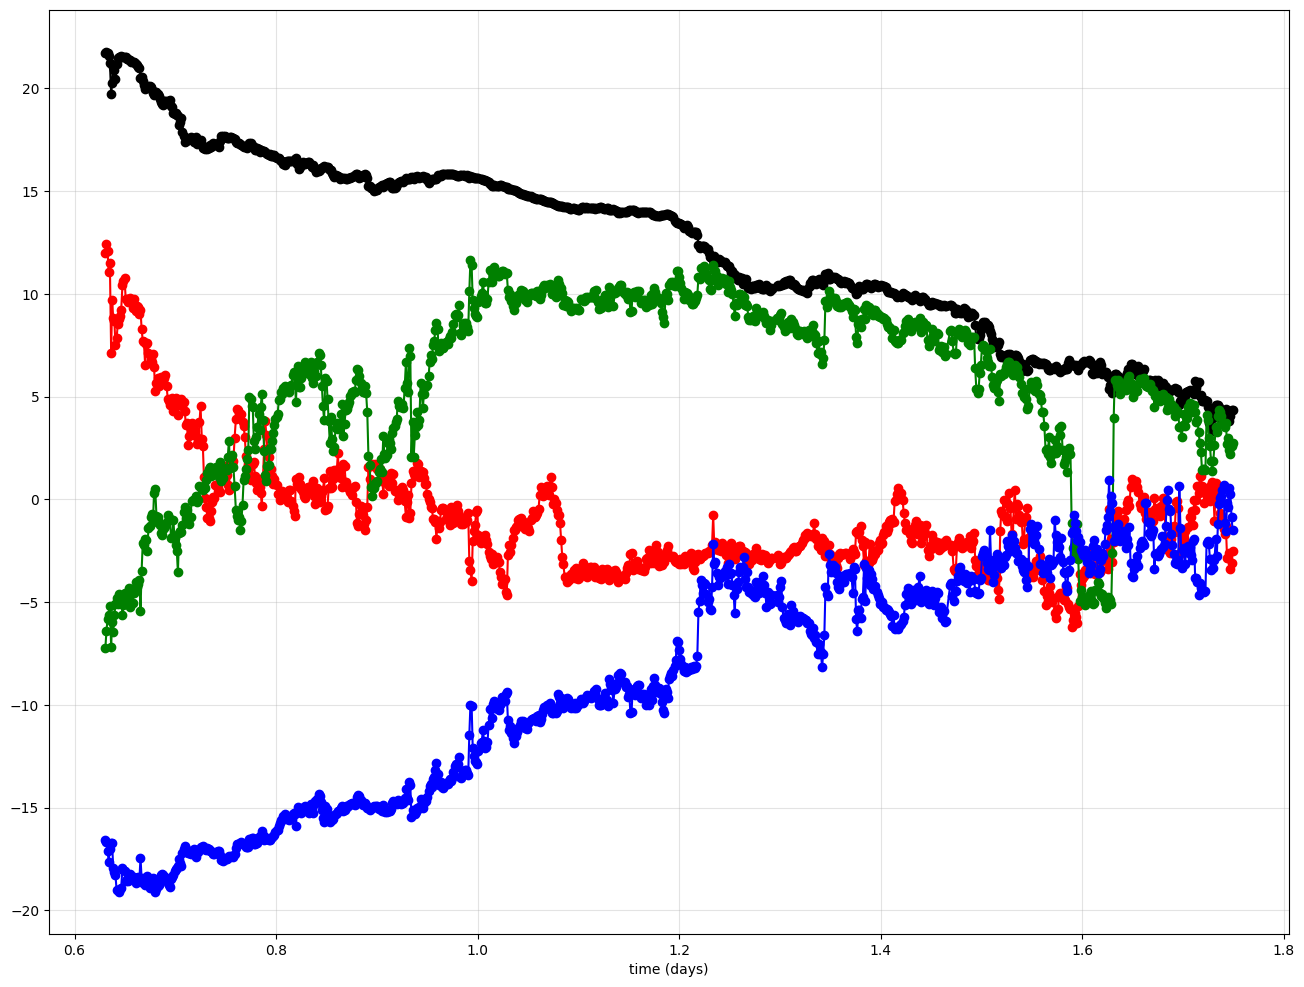

In [8]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.plot(df_event["time_days"], df_event["B"], "-ok")
ax.plot(df_event["time_days"], df_event["B_x"], "-or")
ax.plot(df_event["time_days"], df_event["B_y"], "-og")
ax.plot(df_event["time_days"], df_event["B_z"], "-ob")
ax.set_xlabel("time (days)")
ax.grid(alpha=0.35)

Idea: How good is intermediate variance?

In [72]:
N_IMPACT_PARAMETER = 101
N_EXPERIMENTS = 1
y_0_range = np.linspace(-0.95, 0.95, N_IMPACT_PARAMETER, endpoint=True)

df = []# pd.DataFrame(columns=["y_0", "random_seed", "noise_type", "e_x", "e_y", "_z", "angle_difference"])

time_stencil = np.linspace(0, 1, 51)

for idx, y_0 in enumerate(y_0_range):
    for n_experiment in range(N_EXPERIMENTS):
        for delta in np.linspace(0.4, 1.0, 7, endpoint=True):
            ec_model = ECModel(delta=delta, psi=0.0)
            random_seed = N_EXPERIMENTS*idx + n_experiment
            epsilon = 0.08
            noise_type = None
            result = {"y_0": y_0, "random_seed": random_seed, "epsilon": epsilon, "noise_type": noise_type, "delta": delta}
            
            df_test = ec_model.simulate_crossing(v_sc=450, y_0=y_0, theta=0.0, time_stencil=time_stencil, noise_type=noise_type, random_seed=random_seed, epsilon=epsilon)
            B_field = df_test[["B_x", "B_y", "B_z"]].to_numpy()
            
            M = np.cov(B_field.transpose())
            eigenvalues, W = np.linalg.eig(M)

            index_min: int = np.argmin(eigenvalues)
            index_max: int = np.argmax(eigenvalues)
            index_intermediate: int = 3 - index_min - index_max

            estimated_ax = W[:, index_intermediate]

            # Correct the sign.
            if estimated_ax[2] < 0:
                estimated_ax *= (-1)

            result["e_x"] = estimated_ax[0]
            result["e_y"] = estimated_ax[1]
            result["e_z"] = estimated_ax[2]

            angle_difference = np.rad2deg(np.arccos(abs(estimated_ax[2])))
            result["angle_difference"] = angle_difference

            df.append(result)

df = pd.DataFrame(df)

In [53]:
df.head()

,y_0,random_seed,epsilon,noise_type,e_x,e_y,e_z,angle_difference
0,-0.95,0,0.08,None,-0.312430,-5.165843e-16,0.949941,18.205711
1,-0.95,0,0.08,None,-0.307207,-4.544624e-16,0.951643,17.890978
2,-0.95,0,0.08,None,-0.280848,-4.262455e-16,0.959752,16.310814
3,-0.95,0,0.08,None,-0.230292,-7.883082e-16,0.973121,13.314289
4,-0.95,0,0.08,None,-0.145396,-4.080210e-16,0.989374,8.360206


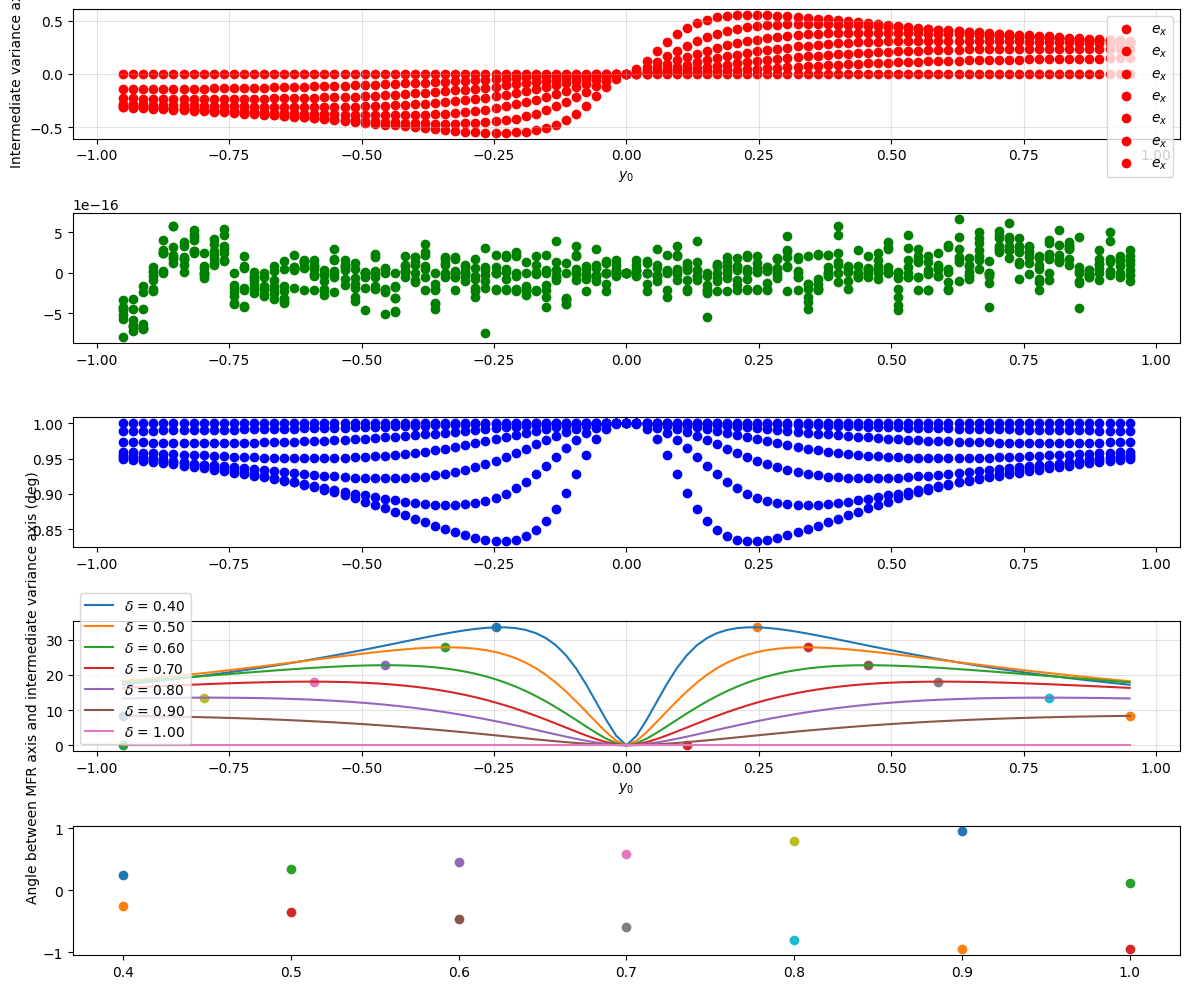

In [ ]:
fig, ax = plt.subplots(5, 1, tight_layout=True, figsize=(12, 10))
distinct_deltas = sorted(list(set(df["delta"])))

for delta in distinct_deltas:
    df_filtered = df.loc[df["delta"] == delta, :]
    ax[0].scatter(df_filtered["y_0"], df_filtered["e_x"], label="$e_x$", c="r")
    ax[1].scatter(df_filtered["y_0"], df_filtered["e_y"], label="$e_y$", c="g")
    ax[2].scatter(df_filtered["y_0"], df_filtered["e_z"], label="$e_z$", c="b")
    # ax[0].plot(df["y_0"], estimated_axis[:, 1])#, label="$e_y$")
    # ax[0].plot(df["y_0"], estimated_axis[:, 2])#, label="$e_z$")
    ax[0].set_xlabel("$y_0$")
    ax[0].set_ylabel("Intermediate variance axis")
    ax[0].legend()
    ax[0].grid(alpha=0.35)

    # Left peak.
    df_filtered_left = df_filtered.loc[df_filtered["y_0"] < 0, :].reset_index(drop=True)
    left_maximum_idx = int(np.argmax(df_filtered_left["angle_difference"]))
    max_left_angle_difference = df_filtered_left.loc[left_maximum_idx, "angle_difference"]
    left_maximum_y_0 = df_filtered_left.loc[left_maximum_idx, "y_0"]

    # Right peak.
    df_filtered_right = df_filtered.loc[df_filtered["y_0"] > 0, :].reset_index(drop=True)
    right_maximum_idx = int(np.argmax(df_filtered_right["angle_difference"]))
    max_right_angle_difference = df_filtered_right.loc[right_maximum_idx, "angle_difference"]
    right_maximum_y_0 = df_filtered_right.loc[right_maximum_idx, "y_0"]

    ax[3].plot(df_filtered["y_0"], df_filtered["angle_difference"], "-", label=f"$\\delta$ = {delta:.2f}")
    ax[3].scatter(left_maximum_y_0, max_left_angle_difference)
    ax[3].scatter(right_maximum_y_0, max_right_angle_difference)
    ax[3].set_xlabel("$y_0$")
    ax[3].set_ylabel("Angle between MFR axis and intermediate variance axis (deg)")
    ax[3].grid(alpha=0.35)

    ax[4].scatter(delta, right_maximum_y_0)
    ax[4].scatter(delta, left_maximum_y_0)
ax[3].legend()
plt.show()

Idea: use intermediate variance method for this, to determine the flux-rope axis. This way we do no rely on the optimiser to do so ans achieve better performance.
If there is noise, this noise should affect all coordinates at the same time, so this method should be robust to noise.

In [11]:
np.var(df_test[["B_x", "B_y", "B_z"]])

/Users/macbookpro/Documents/MagneticFluxRopeModels/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4316: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


B_x    0.002630
B_y    0.226323
B_z    0.002117
dtype: float64

In [12]:
model_params = {
    "delta": {"mode": "optimised", "initial_value": 0.8, "bounds": [0.3, 1]},
    #"psi": {"mode": "optimised", "initial_value": math.radians(45), "bounds": [0.01, math.radians(180)*0.99]},
    "psi": {"mode": "fixed", "value": math.radians(45)},
    "tau": {"mode": "optimised", "initial_value": 1.4, "bounds": [0.1, 2.0]},
    "B_z_0": {"mode": "optimised", "initial_value": 15.0, "bounds": [1, 20]},
    "R": {"mode": "optimised", "bounds": [0.1, 0.4]}
    }

crossing_params = {
    "y_0": {"mode": "optimised", "initial_value": 0.0, "bounds": [-0.95, 0.95]},
    "v_sc": {"mode": "fixed", "value": 480.0}
    }
result = ECModel.fit(ECModel, df_event, model_params, crossing_params, residue_method="RMSE")

result[0]
result[1]
result[2]
result[3]

TypeError: EllipticalCylindricalModel.simulate_crossing() got an unexpected keyword argument 'num_points'

In [ ]:
result[0]

ECModel with parameters:
        - Geometrical:
            - delta = 0.968
            - psi = 45.000 deg
            - R = 0.250 AU
        - Field:
            - n = 1
            - m = 0
            - tau = 0.100
            - C_nm = 1.000
            - B_z_0 = 1.242 nT
            - handedness = 1.

In [ ]:
result[1]

{'y_0': np.float64(-0.95), 'v_sc': 480.0, 'num_points': 107}

Text(0.5, 0, 'time (s)')

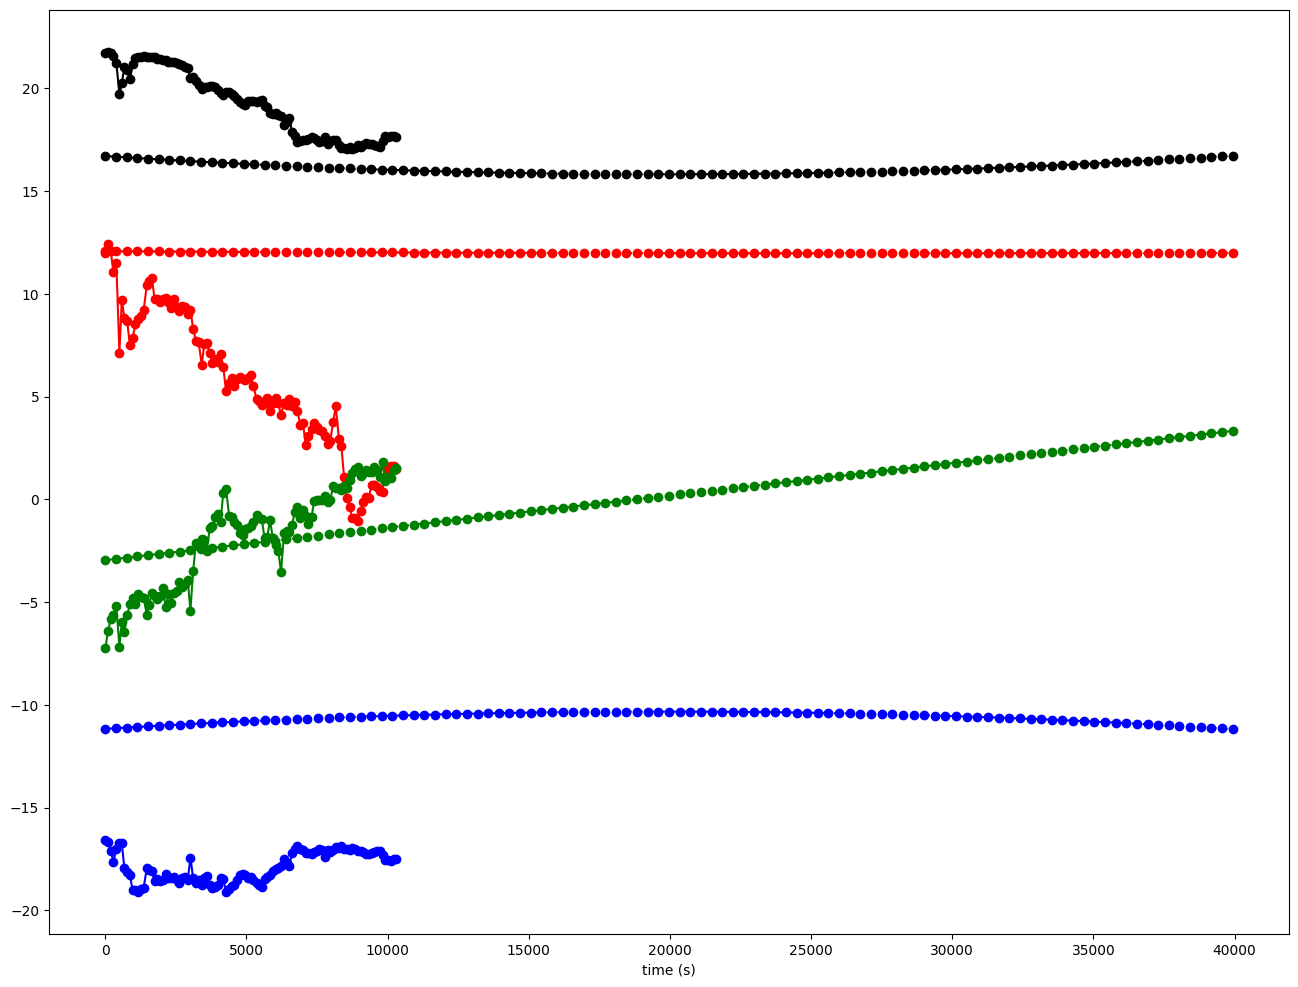

In [ ]:
df_fitted = result[2]

fig, ax = plt.subplots(figsize=(16, 12))
ax.plot(df_event["time"], df_event["B"], "-ok")
ax.plot(df_fitted["time"], df_fitted["B"], "--ok")

ax.plot(df_event["time"], df_event["B_x"], "-or")
ax.plot(df_fitted["time"], df_fitted["B_x"], "--or")

ax.plot(df_event["time"], df_event["B_y"], "-og")
ax.plot(df_fitted["time"], df_fitted["B_y"], "--og")

ax.plot(df_event["time"], df_event["B_z"], "-ob")
ax.plot(df_fitted["time"], df_fitted["B_z"], "--ob")
ax.set_xlabel("time (s)")

# plt.plot(df_fitted["time"], df_fitted["B"], "-ok")
# plt.plot(df_fitted["time"], df_fitted["B_x"], "-or")
# plt.plot(df_fitted["time"], df_fitted["B_y"], "-og")
# plt.plot(df_fitted["time"], df_fitted["B_z"], "-ob")